---
<h1><font color=red><strong><div align="center">COVID DETECTION <strong></font><h1></div>
<div align="center"><img src="https://media.lactualite.com/2020/03/b93f0a42-2871.jpg" alt="drawing" width="300"/>

---

*The aim of this model is to give COVID's prediction case, to help for diagnostic.*<br>
*The prediction will be given from medical radio.*<br>
*The dataset is from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database*<br>
*he is divised in 3 categories:*<br>
* Normal radio
* Viral Peumonia radio
* COVID radio

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
import matplotlib.cm as cm
from IPython.display import Image
import pandas as pd
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
tf.config.experimental.set_memory_growth(gpu[1], True)
if gpu:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpu[0], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)
#tf.config.run_functions_eagerly(True)
#mirrored_strategy = tf.distribute.MirroredStrategy(
#cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

# LOADING AND PREPROCESSING DATA

In [2]:
import pathlib
train_folder = pathlib.Path("../files2")
train_folder

WindowsPath('../files2')

In [3]:
all_image_paths = [str(img_path) for img_path in list(train_folder.glob("*/*.png"))]
all_image_paths[-5:]

['..\\files2\\Viral Pneumonia\\Viral Pneumonia (995).png',
 '..\\files2\\Viral Pneumonia\\Viral Pneumonia (996).png',
 '..\\files2\\Viral Pneumonia\\Viral Pneumonia (997).png',
 '..\\files2\\Viral Pneumonia\\Viral Pneumonia (998).png',
 '..\\files2\\Viral Pneumonia\\Viral Pneumonia (999).png']

In [4]:
len(all_image_paths) # number of images total

3361

In [5]:
df = pd.DataFrame(all_image_paths)
df = df.rename(columns={0:'X'})
df.head()


,X
0,..\files2\COVID\COVID (1).png
1,..\files2\COVID\COVID (10).png
2,..\files2\COVID\COVID (100).png
3,..\files2\COVID\COVID (1000).png
4,..\files2\COVID\COVID (1001).png


In [6]:
labels = []
for label in train_folder.iterdir():
  labels += [label.name]
  
labels

['COVID', 'NORMAL', 'Viral Pneumonia']

In [7]:
label_index = {}

for i, label in enumerate(labels):
  label_index[label]= i

  
label_index  

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

In [8]:
# Create lables for each image
all_image_labels = [label_index[path.parent.name] for path in list(train_folder.glob("*/*"))]

df['Y'] = all_image_labels
df.tail()

,X,Y
3356,..\files2\Viral Pneumonia\Viral Pneumonia (995...,2
3357,..\files2\Viral Pneumonia\Viral Pneumonia (996...,2
3358,..\files2\Viral Pneumonia\Viral Pneumonia (997...,2
3359,..\files2\Viral Pneumonia\Viral Pneumonia (998...,2
3360,..\files2\Viral Pneumonia\Viral Pneumonia (999...,2


In [9]:
df_shuffled=df.sample(frac=1).reset_index(drop=True)
display(df_shuffled.head())

print('\n')
print('\n')
print('Labels numbers :')
print('\n')
print(df_shuffled['Y'].value_counts())

,X,Y
0,..\files2\COVID\COVID (296).png,0
1,..\files2\Viral Pneumonia\Viral Pneumonia (99)...,2
2,..\files2\Viral Pneumonia\Viral Pneumonia (555...,2
3,..\files2\NORMAL\NORMAL (432).png,1
4,..\files2\Viral Pneumonia\Viral Pneumonia (118...,2






Labels numbers :


1    1194
0    1100
2    1067
Name: Y, dtype: int64


In [10]:
X = df_shuffled['X']
Y = df_shuffled['Y'].values

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=0,stratify=Y)

train_tensor = tf.data.Dataset.from_tensor_slices((X_train))
validation_tensor = tf.data.Dataset.from_tensor_slices((X_test))

label_train = tf.data.Dataset.from_tensor_slices(y_train) 
label_val= tf.data.Dataset.from_tensor_slices(y_test)


In [12]:
def data_aug(img, label):

  img= tf.io.read_file(img)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [256, 256])
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_contrast(img, 0.5, 1.5)
  #img = tf.image.random_crop(img, [256,256,3])
  img = img / 255

  return img, label

def load_and_preprocess_images(img):
  img = tf.io.read_file(img)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [256, 256])
  img = img / 255
  return img

In [13]:
train_data = tf.data.Dataset.zip((train_tensor, label_train))
repeated_train_data= train_data.repeat(1)
repeated_train_data= repeated_train_data.map(data_aug)

In [14]:
#train_tensor = train_tensor.map(load_and_preprocess_images)
#train_data = tf.data.Dataset.zip((train_tensor, label_train))

In [15]:
validation_tensor = validation_tensor.map(load_and_preprocess_images)
validation_data = tf.data.Dataset.zip((validation_tensor, label_val))

In [16]:
print('size of train set is {} total images'.format(len(repeated_train_data)))
print('size of validation set is {} images total'.format(len(validation_data)))

size of train set is 2352 total images
size of validation set is 1009 images total


In [17]:
repeated_train_data = repeated_train_data.shuffle(len(repeated_train_data)).batch(10)

In [18]:
#train_data = train_data.shuffle(len(train_data)).batch(16)
validation_data = validation_data.batch(10)

In [19]:
for tensor,label in repeated_train_data.take(1):
    print (tensor)
    print(label)

tf.Tensor(
[[[[ 3.80185425e-01  3.80185425e-01  3.80185425e-01]
   [ 3.80833238e-01  3.80833238e-01  3.80833238e-01]
   [ 3.85449022e-01  3.85449022e-01  3.85449022e-01]
   ...
   [ 2.55622298e-01  2.55622298e-01  2.55622298e-01]
   [ 2.50092983e-01  2.50092983e-01  2.50092983e-01]
   [ 2.36631259e-01  2.36631259e-01  2.36631259e-01]]

  [[ 3.84047985e-01  3.84047985e-01  3.84047985e-01]
   [ 3.78365666e-01  3.78365666e-01  3.78365666e-01]
   [ 3.73265117e-01  3.73265117e-01  3.73265117e-01]
   ...
   [ 2.64174044e-01  2.64174044e-01  2.64174044e-01]
   [ 2.43503407e-01  2.43503407e-01  2.43503407e-01]
   [ 2.34888598e-01  2.34888598e-01  2.34888598e-01]]

  [[ 3.70706052e-01  3.70706052e-01  3.70706052e-01]
   [ 3.80051553e-01  3.80051553e-01  3.80051553e-01]
   [ 3.77738088e-01  3.77738088e-01  3.77738088e-01]
   ...
   [ 2.58319825e-01  2.58319825e-01  2.58319825e-01]
   [ 2.47680962e-01  2.47680962e-01  2.47680962e-01]
   [ 2.36027703e-01  2.36027703e-01  2.36027703e-01]]

  ...

 

In [20]:
for tensor,label in validation_data.take(1):
    print (tensor)
    print(label)

tf.Tensor(
[[[[0.15889749 0.15889749 0.15889749]
   [0.1686314  0.1686314  0.1686314 ]
   [0.17592019 0.17592019 0.17592019]
   ...
   [0.22465426 0.22465426 0.22465426]
   [0.23743083 0.23743083 0.23743083]
   [0.23853533 0.23853533 0.23853533]]

  [[0.16799544 0.16799544 0.16799544]
   [0.16291708 0.16291708 0.16291708]
   [0.17199755 0.17199755 0.17199755]
   ...
   [0.24366575 0.24366575 0.24366575]
   [0.2371825  0.2371825  0.2371825 ]
   [0.22742406 0.22742406 0.22742406]]

  [[0.16393013 0.16393013 0.16393013]
   [0.1667465  0.1667465  0.1667465 ]
   [0.16859454 0.16859454 0.16859454]
   ...
   [0.2274785  0.2274785  0.2274785 ]
   [0.22541037 0.22541037 0.22541037]
   [0.22088587 0.22088587 0.22088587]]

  ...

  [[0.08444501 0.08444501 0.08444501]
   [0.1354211  0.1354211  0.1354211 ]
   [0.1641598  0.1641598  0.1641598 ]
   ...
   [0.18328199 0.18328199 0.18328199]
   [0.15320483 0.15320483 0.15320483]
   [0.10465686 0.10465686 0.10465686]]

  [[0.08896664 0.08896664 0.088966

In [21]:
#with mirrored_strategy.scope():
def build_model_2():

    input_tensor = tf.keras.Input(shape=(256,256,3))
    Xception = tf.keras.applications.Xception(input_shape=(256,256,3),include_top=False, input_tensor=input_tensor)
    Xception.trainable = False

    top_model = tf.keras.Sequential()
    top_model.add(tf.keras.layers.GlobalMaxPooling2D())
    top_model.add(tf.keras.layers.Dense(4096, activation=tf.nn.relu))
    #top_model.add(tf.keras.layers.Dropout(0.3))
    top_model.add(tf.keras.layers.Dense(4096, activation=tf.nn.relu))
    #top_model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
    top_model.add(tf.keras.layers.Dropout(0.1))
    top_model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

    model = tf.keras.Model(inputs=Xception.input, outputs=top_model(Xception.output))

    model.compile(optimizer = 'Adam',
          loss= tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics = tf.keras.metrics.SparseCategoricalAccuracy())
    return model

In [22]:
model = build_model_2()

83689472/83683744 [==============================] - 1s 0us/step


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [26]:

from keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint will be use to save model each time performance are better
checkpoint = ModelCheckpoint("model_Xception.h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early stopping will stop training if the validation accuracy don't progress  
early = EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0, patience=20, verbose=1, mode='auto')


In [27]:
history = model.fit(x=repeated_train_data, validation_data=validation_data, epochs=100, callbacks=[checkpoint,early])

Epoch 1/100
236/236 [==============================] - 38s 85ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.8571 - val_loss: 0.2609 - val_sparse_categorical_accuracy: 0.8920

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.89197, saving model to model_Xception.h5
Epoch 2/100
236/236 [==============================] - 36s 80ms/step - loss: 0.2673 - sparse_categorical_accuracy: 0.9031 - val_loss: 0.1840 - val_sparse_categorical_accuracy: 0.9257

Epoch 00002: val_sparse_categorical_accuracy improved from 0.89197 to 0.92567, saving model to model_Xception.h5
Epoch 3/100
236/236 [==============================] - 37s 78ms/step - loss: 0.2305 - sparse_categorical_accuracy: 0.9184 - val_loss: 0.1481 - val_sparse_categorical_accuracy: 0.9405

Epoch 00003: val_sparse_categorical_accuracy improved from 0.92567 to 0.94054, saving model to model_Xception.h5
Epoch 4/100
236/236 [==============================] - 36s 78ms/step - loss: 0.2213 - sparse_categorical_accurac

### The final accuracy for the model is 96% Epoch 20 

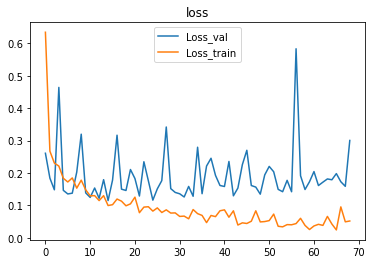

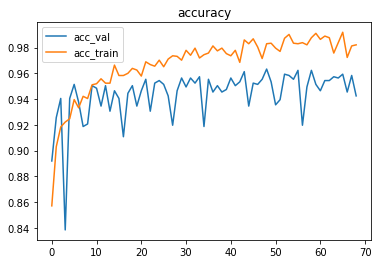

In [28]:
loss_curve = history.history["loss"]
loss_val = history.history["val_loss"]
acc_curve = history.history["sparse_categorical_accuracy"]
acc_val = history.history["val_sparse_categorical_accuracy"]

plt.plot(loss_val,label="Loss_val")
plt.plot(loss_curve,label="Loss_train")
plt.legend()
plt.title("loss")
plt.show()

plt.plot(acc_val, label="acc_val" )
plt.plot(acc_curve, label="acc_train" )
plt.legend()
plt.title("accuracy")
plt.show()

# GRAD CAM

*We will use gradiant to visualize the model detection's result*

In [29]:
#for the prepocessing of image
img_size = (256, 256)
preprocess_input = tf.keras.applications.xception.preprocess_input

#we selected the last convolution layers
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = ["sequential"]


In [30]:
def get_img_array(img_path, size):
    
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    #classifier = model.get_layer(classifier_layer_names)
    #classifier_model = tf.keras.Model(classifier.input, classifier.output)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [31]:
import glob
from PIL import Image
covid = "../Images/Train/COVID/*"
pneumo = "../Images/Train/Viral Pneumonia/*"
normal = "../Images/Train/NORMAL/*"
path_covid = glob.glob(covid)[150]
path_pneumo = glob.glob(pneumo)[150]
path_normal = glob.glob(normal)[150]
img_covid = Image.open(glob.glob(covid)[150])
img_pneumo = Image.open(glob.glob(pneumo)[150])
img_normal = Image.open(glob.glob(normal)[150])

In [32]:
glob.glob(covid)[86]

'../Images/Train/COVID\\COVID (1086).png'

In [33]:
# Prepare image
img_array_c = preprocess_input(get_img_array(path_covid, size=img_size))
img_array_p = preprocess_input(get_img_array(path_pneumo, size=img_size))
img_array_n = preprocess_input(get_img_array(path_normal, size=img_size))

# Make model
model = model #tf.keras.models.load_model("model_VGG19.h5")
# Generate class activation heatmap
heatmap_c = make_gradcam_heatmap(
    img_array_c, model, last_conv_layer_name, classifier_layer_names
)
heatmap_p = make_gradcam_heatmap(
    img_array_p, model, last_conv_layer_name, classifier_layer_names
)
heatmap_n = make_gradcam_heatmap(
    img_array_n, model, last_conv_layer_name, classifier_layer_names
)


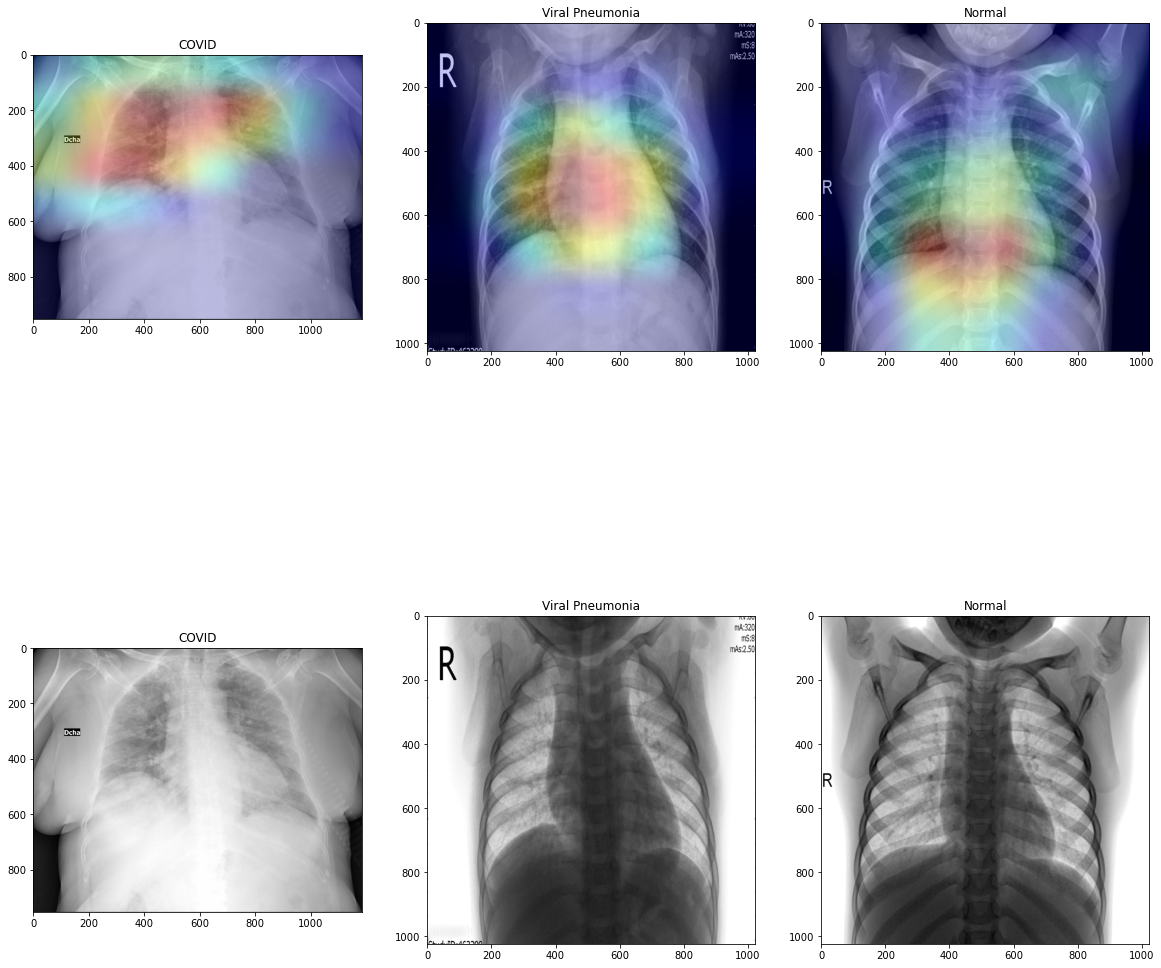

In [34]:
def superpose(path, heatmap):
    # We load the original image
    img = tf.keras.preprocessing.image.load_img(path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    return  tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    

# Save the superimposed image
#save_path = "grad_cam_radio.jpg"
#superimposed_img.save(save_path)

# Display Grad CAM
#display(Image(save_path))
plt.figure(figsize=(20,20))

plt.subplot(2,3,1)
plt.imshow(superpose(path_covid,heatmap_c))
plt.title("COVID")

plt.subplot(2,3,2)
plt.imshow(superpose(path_pneumo,heatmap_p))
plt.title("Viral Pneumonia")

plt.subplot(2,3,3)
plt.imshow(superpose(path_normal,heatmap_n))
plt.title("Normal")

plt.subplot(2,3,4)
plt.imshow(img_covid,cmap='binary')
plt.title("COVID")

plt.subplot(2,3,5)
plt.imshow(img_pneumo,cmap='binary')
plt.title("Viral Pneumonia")

plt.subplot(2,3,6)
plt.imshow(img_normal,cmap='binary')
plt.title("Normal")

plt.show()